In [1]:
import os
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model_name = 'trained_cnn_v1.0_non_adversary_example'

# Import the image that will be used as adversarial example
# Further also load the model, because some of the adversarial example uses gradient information

train_set = np.load('adversarial_example/raw/train_set.npz')
test_set = np.load('adversarial_example/raw/test_set.npz')

# Get sample x and y
x_train, y_train = train_set['x'], train_set['y']
x_test, y_test = test_set['x'], test_set['y'] 

# Every loaded sample set or x_test is normal image which have label 0 : non-adversarial example
#y_test = np.full(shape=len(x_test), fill_value=0)

model = tf.keras.models.load_model(os.path.join('weight', model_name, 'conf_weight.h5'))
model_linear = tf.keras.models.load_model(os.path.join('weight', model_name, 'conf_weight.h5'))

In [2]:
#print(model.get_layer(index=-1).activation)
#model.get_layer(index=-1).activation = tf.keras.activations.linear
#print(model.get_layer(index=-1).activation)
#print(model.layers[-1].output.get_shape())

In [3]:
from collections import Counter
from adversarial_robustness_toolbox.art.estimators.classification import KerasClassifier

def expand_dim(image, label):
    return np.expand_dims(image, axis=0), np.expand_dims(label, axis=0)

def get_tf_classifier(model):
    return KerasClassifier(model=model, clip_values=(0, 1))

# Calculate each class image distribution in each set
def calculate_distribution(y):
    counter = Counter(y)
    for k, v in counter.items():
        per= v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

model_linear.get_layer(index=-1).activation = tf.keras.activations.linear

classifier = get_tf_classifier(model=model)
classifier_linear = get_tf_classifier(model=model_linear)

c:\Users\andro\.conda\envs\adversarial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\andro\.conda\envs\adversarial\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [4]:
print("Train distribution : ")
calculate_distribution(y_train)
print("Test distribution : ")
calculate_distribution(y_test)

Train distribution : 
Class=1, n=545 (33.211%)
Class=0, n=534 (32.541%)
Class=2, n=562 (34.247%)
Test distribution : 
Class=1, n=181 (33.090%)
Class=0, n=178 (32.541%)
Class=2, n=188 (34.369%)


In [5]:
#print(model_linear.get_layer(index=-1).activation)

In [6]:
#tf.keras.utils.to_categorical([1], num_classes=3).shape

In [16]:
# Label 0 : non-adversarial example
# Label 1 : adversarial example : white-box attack
# Label 2 : adversarial example : black-box attack
# Create multiple function of adversarial example

%load_ext autoreload
%autoreload 2

from adversarial_robustness_toolbox.art import attacks

# White-box attack
def fgsm(classifier:KerasClassifier, image, label, epsilon=0.1, group=False, targeted=False):
    if group is not True:
    # Expand dim
        image, label = expand_dim(image, label)

    fgsm_instance = attacks.evasion.FastGradientMethod(estimator=classifier, eps=epsilon, targeted=targeted)
    adversary_example = fgsm_instance.generate(x=image, y=label)

    return adversary_example[0]

def deepfool(classifier:KerasClassifier, image, label, epsilon=0.1, group=False):
    if group is not True:
        # Expand dim
        image, label = expand_dim(image, label)

    # Define deep fool class
    deepfool_instance = attacks.evasion.DeepFool(classifier=classifier, epsilon=epsilon, verbose=False)
    adversary_example = deepfool_instance.generate(x=image, y=label)

    return adversary_example[0]

def wasserstein(classifier:KerasClassifier, image, label, epsilon=0.1, epsilon_factor=1.1, eps_iter=10, group=False, targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)
    
    wasserstein_instance = attacks.evasion.Wasserstein(
        estimator=classifier,
        eps_step=0.1,
        eps=epsilon,
        eps_factor=epsilon_factor,
        regularization=1500.0,
        eps_iter=eps_iter,
        targeted=targeted,
        verbose=False
    )
    adversary_example = wasserstein_instance.generate(x=image, y=label)

    return adversary_example[0]

def carlini(classifier:KerasClassifier, image, label, group=False, type_attack='l2', targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)

    if type_attack == 'l0':
        carlini_instance = attacks.evasion.CarliniL0Method(classifier=classifier, targeted=targeted, verbose=False)
    if type_attack == 'l2':
        carlini_instance = attacks.evasion.CarliniL2Method(classifier=classifier, max_doubling=10, targeted=targeted, verbose=False)
    if type_attack == 'linf':
        carlini_instance = attacks.evasion.CarliniLInfMethod(classifier=classifier, const_factor=4.0, targeted=targeted, verbose=False)

    adversary_example = carlini_instance.generate(x=image, y=label)

    return adversary_example[0]

def elastic_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, binary_search=9):
    if group is not True:
        image, label = expand_dim(image, label)

    elastic_instance = attacks.evasion.ElasticNet(classifier=classifier, binary_search_steps=binary_search, verbose=False)
    adversary_example = elastic_instance.generate(x=image, label=label)

    return adversary_example[0]


'''
def auto_pgd(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
        image, label = expand_dim(image, label)

    # Replace last layer softmax with linear activation function
    auto_pgd_instance = attacks.evasion.AutoProjectedGradientDescent(estimator=classifier)
    adversary_example = auto_pgd_instance.generate(x=image, y=label)

    return adversary_example[0]

def hclu(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
        image, label = expand_dim(image, label)

    hclu_instance = attacks.evasion.HighConfidenceLowUncertainty(classifier=classifier)
    adversary_example = hclu_instance.generate(x=image, y=label)

    return adversary_example[0]


def brendel_bethge(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
    # Expand dim
        image, label = expand_dim(image, label)

    brendel_bethge_instance = attacks.evasion.BrendelBethgeAttack(estimator=classifier)
    adversary_example = brendel_bethge_instance.generate(x=image, y=label)

    return adversary_example[0]
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\ndef auto_pgd(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n        image, label = expand_dim(image, label)\n\n    # Replace last layer softmax with linear activation function\n    auto_pgd_instance = attacks.evasion.AutoProjectedGradientDescent(estimator=classifier)\n    adversary_example = auto_pgd_instance.generate(x=image, y=label)\n\n    return adversary_example[0]\n\ndef hclu(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n        image, label = expand_dim(image, label)\n\n    hclu_instance = attacks.evasion.HighConfidenceLowUncertainty(classifier=classifier)\n    adversary_example = hclu_instance.generate(x=image, y=label)\n\n    return adversary_example[0]\n\n\ndef brendel_bethge(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n    # Expand dim\n        image, label = expand_dim(image, label)\n\n    brendel_bethge_instance = attacks.evasion.BrendelBethgeAttack(estimato

<h2> Demo Adversarial Attack test </h2>

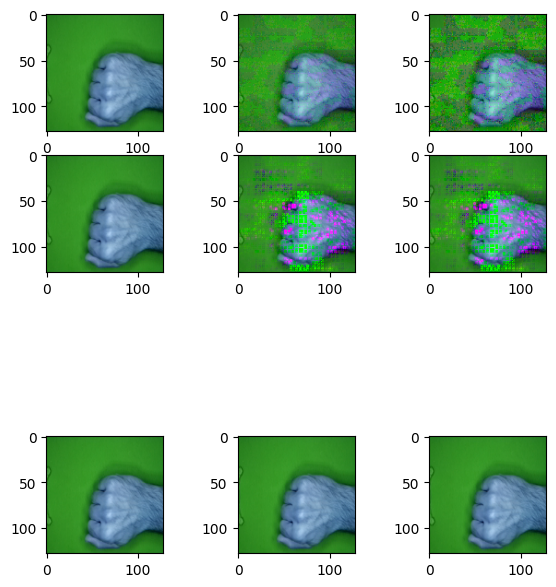

In [17]:
import matplotlib.pyplot as plt

test_image = x_test[0]
label = tf.keras.utils.to_categorical(y_test[0], num_classes=3)
#generated_fgsm = fgsm(model=model, image=test_image, label=label, epsilon=0.05)

width_length_dim = (4, 3)

array_of_adversaries = [test_image]

# FGSM
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

fgsm1 = fgsm(classifier=classifier, image=test_image, label=label, epsilon=0.05, targeted=False)
array_of_adversaries.append(fgsm1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(fgsm1)

fgsm2 = fgsm(classifier=classifier, image=test_image, label=label, epsilon=0.1, targeted=False)
array_of_adversaries.append(fgsm2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(fgsm2)

# deepfool
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

deepfool1 = deepfool(classifier=classifier, image=test_image, label=label, epsilon=0.05)
array_of_adversaries.append(deepfool1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(deepfool1)

deepfool2 = deepfool(classifier=classifier, image=test_image, label=label, epsilon=0.1)
array_of_adversaries.append(deepfool2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(deepfool2)

'''
# Wasserstein
fig.add_subplot(width_length_dim[0], width_length_dim[1], 7)
plt.imshow(test_image)

wasserstein1 = wasserstein(classifier=classifier, image=test_image, epsilon=0.3, epsilon_factor=1.3, eps_iter=3, label=label, targeted=False)
array_of_adversaries.append(wasserstein1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 8)
plt.imshow(wasserstein1)

wasserstein2 = wasserstein(classifier=classifier, image=test_image, epsilon=0.6, epsilon_factor=1.5, eps_iter=3, label=label, targeted=False)
array_of_adversaries.append(wasserstein2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 9)
plt.imshow(wasserstein2)'''

# Carlini wagner
fig.add_subplot(width_length_dim[0], width_length_dim[1], 10)
plt.imshow(test_image)

cw1 = carlini(classifier=classifier, image=test_image, label=label, type_attack='linf', targeted=False)
array_of_adversaries.append(cw1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 11)
plt.imshow(cw1)

cw2 = carlini(classifier=classifier, image=test_image, label=label, type_attack='l2', targeted=False)
array_of_adversaries.append(cw2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 12)
plt.imshow(cw2)

In [18]:
# Black box attack
def one_pixel_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, es=1):
    if group is not True:
        image, label = expand_dim(image, label)

    one_pixel_instance = attacks.evasion.PixelAttack(classifier=classifier, targeted=targeted, es=es, verbose=False)
    adversary_example = one_pixel_instance.generate(x=image, y=label)

    return adversary_example[0]

def zero_order_atk(classifier:KerasClassifier, image, label, binary_search_steps=1, group=False, targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)

    zoo_attack = attacks.evasion.ZooAttack(classifier=classifier, binary_search_steps=binary_search_steps, abort_early=True, confidence=0.2, targeted=targeted, verbose=False)
    adversary_example = zoo_attack.generate(x=image, y=label)

    return adversary_example[0]

def threshold_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, es=1):
    if group is not True:
        image, label = expand_dim(image, label)

    thresh_attack = attacks.evasion.ThresholdAttack(classifier=classifier, th=5, es=es, targeted=targeted, verbose=False)
    adversary_example = thresh_attack.generate(x=image, y=label)

    return adversary_example[0]

def simba_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, order='random', epsilon=0.1):
    if group is not True:
        image, label = expand_dim(image, label)

    simba_attack = attacks.evasion.SimBA(classifier=classifier, targeted=targeted, order=order, epsilon=epsilon, verbose=False)
    adversary_example = simba_attack.generate(x=image, y=label)

    return adversary_example[0]

def geometrical_da_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, sigma=0.0002):
    if group is not True:
        image, label = expand_dim(image, label)

    geometrical_atk = attacks.evasion.GeoDA(estimator=classifier, sigma=sigma, verbose=False)
    adversary_example = geometrical_atk.generate(x=image, y=label)

    return adversary_example[0]

def square_attack(classifier:KerasClassifier, image, label, group=False, targeted=False, eps=0.3):
    if group is not True:
        image, label = expand_dim(image, label)

    square_attack = attacks.evasion.SquareAttack(estimator=classifier, eps=eps, nb_restarts=2, verbose=False)
    adversary_Example = square_attack.generate(x=image, y=label)

    return adversary_Example[0]
    

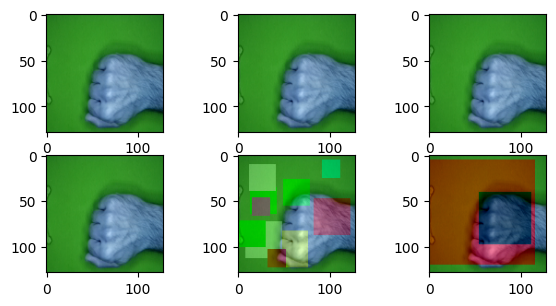

In [19]:
# Elastic Attack
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

elastic1 = elastic_atk(classifier=classifier, image=test_image, label=label, binary_search=3, targeted=False)
array_of_adversaries.append(elastic1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(elastic1)

elastic2 = elastic_atk(classifier=classifier, image=test_image, label=label, binary_search=5, targeted=False)
array_of_adversaries.append(elastic2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(elastic2)

# Square attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

square1 = square_attack(classifier=classifier, image=test_image, label=label, eps=0.2)
array_of_adversaries.append(square1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(square1)

square2 = square_attack(classifier=classifier, image=test_image, label=label, eps=0.3)
array_of_adversaries.append(square2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(square2)

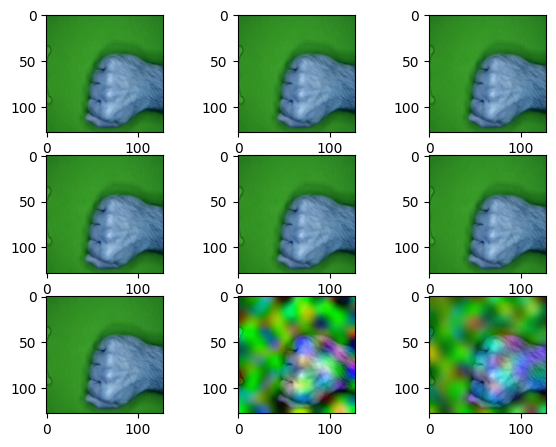

In [20]:
width_length_dim = (4, 3)

fig = plt.figure(figsize=(7, 7))

# One pixel atk
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

onepp1 = one_pixel_atk(classifier=classifier, image=test_image, label=label, targeted=False, es=0)
array_of_adversaries.append(onepp1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(onepp1)

onepp2 = one_pixel_atk(classifier=classifier, image=test_image, label=label, targeted=False, es=1)
array_of_adversaries.append(onepp2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(onepp2)

# simBA attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

simba1 = simba_atk(classifier=classifier, image=test_image, label=label, targeted=False, order='random')
array_of_adversaries.append(simba1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(simba1)

simba2 = simba_atk(classifier=classifier, image=test_image, label=label, targeted=False, order='diag')
array_of_adversaries.append(simba2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(simba2)

# Geometrical attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 7)
plt.imshow(test_image)

geo1 = geometrical_da_atk(classifier=classifier, image=test_image, label=label, targeted=False, sigma=0.0003)
array_of_adversaries.append(geo1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 8)
plt.imshow(geo1)

geo2 = geometrical_da_atk(classifier=classifier, image=test_image, label=label, targeted=False, sigma=0.0006)
array_of_adversaries.append(geo2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 9)
plt.imshow(geo2)

In [21]:
import cv2

def show_classification_result(image, adversaries, label, adversaries_labels):
    label_format = ['paper', 'rock', 'scissors']

    fig, ax = plt.subplots(len(adversaries), 1)
    ax = ax.flatten()
    fig.set_figheight(30)
    fig.set_figwidth(30)

    output = []
    for idx, adv_ex in enumerate(adversaries):
        img_copy = image.copy()
        color = (0, 255, 0)

        adversary_pred = adversaries_labels[idx].argmax()

        adversary_conf = max(adversaries_labels[idx])
        #print(label_format[label], label_format[adversary_pred], label, adversary_pred)
        if label != adversary_pred:
            color = (0, 0, 255)

        # Pui prediction
        cv2.putText(img_copy, label_format[label], (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(adv_ex, label_format[adversary_pred], (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # Put confidence
        cv2.putText(img_copy, str(0), (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        cv2.putText(adv_ex, str(adversary_conf), (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        output.append(np.hstack((img_copy, adv_ex)))

    for idx, a in enumerate(ax):
        a.imshow(output[idx])

# Predict
predicted = classifier.predict(x=array_of_adversaries)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

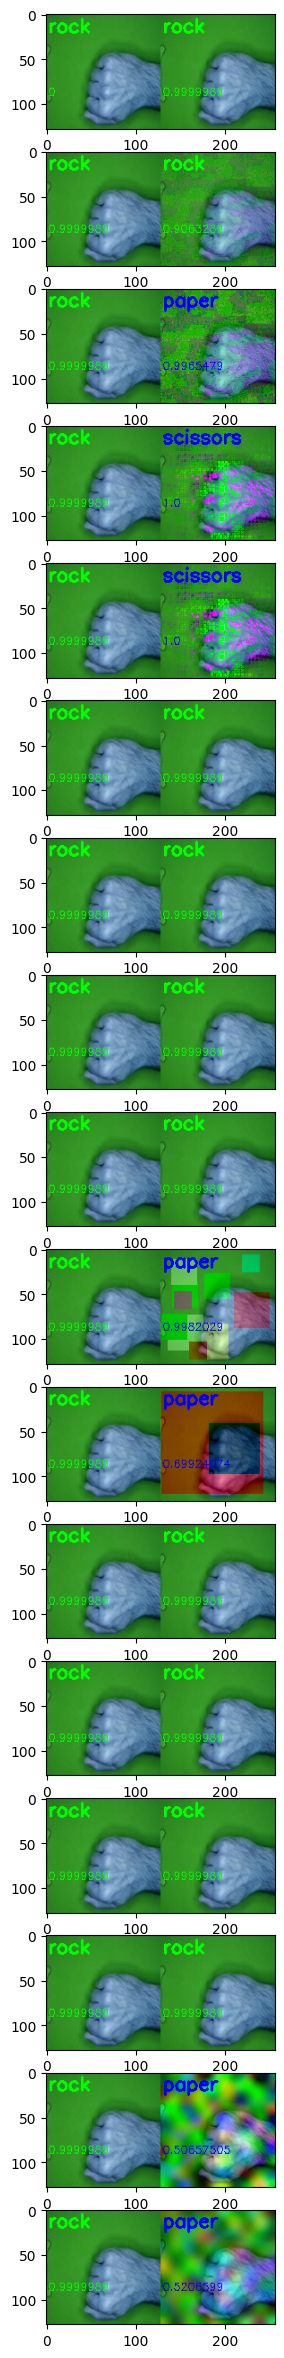

In [23]:
show_classification_result(image=test_image, adversaries=array_of_adversaries, label=y_train[0], adversaries_labels=predicted)

In [24]:
x_test.shape

(547, 128, 128, 3)

In [27]:
import tqdm

def generate_adversarial_example(dataset, dataset_labels, each_class_num):
    def obtain_adversarial_example(img, label, classifier, kind:str='geoda', epsilon:float=0.1, binary_search:int=3, type_attack:str='linf', es:int=0, order:str='diag', sigma:float=0.0003):
        if kind == 'fgsm':
            return fgsm(classifier=classifier, image=img, label=label, epsilon=epsilon), 1
        if kind == 'deepfool':
            return deepfool(classifier=classifier, image=img, label=label, epsilon=epsilon), 1
        if kind == 'elastic':
            return elastic_atk(classifier=classifier, image=img, label=label, binary_search=binary_search, targeted=False), 1
        if kind == 'carlini':
            return carlini(classifier=classifier, image=img, label=label, type_attack=type_attack, targeted=False), 1
        if kind == 'one_pixel':
            return one_pixel_atk(classifier=classifier, image=img, label=label, es=es), 2
        if kind == 'square':
            return square_attack(classifier=classifier, image=img, label=label, eps=epsilon), 2
        if kind == 'simba':
            return simba_atk(classifier=classifier, image=img, label=label, order=order), 2
        if kind == 'geoda':
            return geometrical_da_atk(classifier=classifier, image=img, label=label, sigma=sigma), 2

    categorical_ground_truth = tf.keras.utils.to_categorical(dataset_labels, num_classes=3)

    adversarial_x = []
    adversarial_y = []

    num_class_zero = 0
    num_class_one = 0
    num_class_two = 0
    for idx, img in tqdm.tqdm(enumerate(dataset)):
        if dataset_labels[idx] == 0:
            if num_class_zero <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_zero), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                num_class_zero += 1
                continue
            else:
                pass
        if dataset_labels[idx] == 1:
            if num_class_one <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_one), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                num_class_one += 1
                continue
            else:
                pass
        if dataset_labels[idx] == 2:
            if num_class_two <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_two), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)

                num_class_two += 1
                continue
            else:
                pass
    return adversarial_x, adversarial_y

In [43]:
# Generate for train set
x_test_adv, y_test_adv = generate_adversarial_example(x_test, dataset_labels=y_test, each_class_num=150)

0it [00:00, ?it/s]

Iteration : 0, Each Class Num : 0, Label : 1


1it [01:45, 105.46s/it]

Iteration : 1, Each Class Num : 1, Label : 1


2it [02:03, 53.89s/it] 

Iteration : 2, Each Class Num : 2, Label : 1


3it [02:19, 36.67s/it]

Iteration : 3, Each Class Num : 3, Label : 1


4it [02:35, 28.55s/it]

Iteration : 4, Each Class Num : 4, Label : 1


5it [03:31, 38.49s/it]

Iteration : 5, Each Class Num : 5, Label : 1


6it [05:11, 59.28s/it]

Iteration : 6, Each Class Num : 6, Label : 1


7it [06:04, 57.23s/it]

Iteration : 7, Each Class Num : 7, Label : 1


8it [06:20, 44.02s/it]

Iteration : 8, Each Class Num : 8, Label : 1


9it [07:57, 60.77s/it]

Iteration : 9, Each Class Num : 9, Label : 1


10it [09:36, 72.46s/it]

Iteration : 10, Each Class Num : 10, Label : 1


11it [11:13, 80.12s/it]

Iteration : 11, Each Class Num : 11, Label : 1


12it [11:31, 61.14s/it]

Iteration : 12, Each Class Num : 12, Label : 1


13it [12:59, 69.32s/it]

Iteration : 13, Each Class Num : 13, Label : 1


14it [14:38, 78.31s/it]

Iteration : 14, Each Class Num : 14, Label : 1


15it [14:54, 59.46s/it]

Iteration : 15, Each Class Num : 15, Label : 1


16it [15:49, 58.27s/it]

Iteration : 16, Each Class Num : 16, Label : 1


17it [17:28, 70.30s/it]

Iteration : 17, Each Class Num : 17, Label : 1


18it [19:06, 78.79s/it]

Iteration : 18, Each Class Num : 18, Label : 1


19it [19:23, 60.00s/it]

Iteration : 19, Each Class Num : 19, Label : 1


20it [19:38, 46.71s/it]

Iteration : 20, Each Class Num : 20, Label : 1


21it [19:55, 37.64s/it]

Iteration : 21, Each Class Num : 21, Label : 1


22it [20:11, 31.25s/it]

Iteration : 22, Each Class Num : 22, Label : 1


23it [21:51, 51.93s/it]

Iteration : 23, Each Class Num : 23, Label : 1


24it [23:30, 65.84s/it]

Iteration : 24, Each Class Num : 24, Label : 1


25it [25:06, 75.15s/it]

Iteration : 25, Each Class Num : 25, Label : 1


26it [26:45, 82.07s/it]

Iteration : 26, Each Class Num : 26, Label : 1


27it [28:26, 87.94s/it]

Iteration : 27, Each Class Num : 27, Label : 1


28it [28:42, 66.34s/it]

Iteration : 28, Each Class Num : 28, Label : 1


29it [30:19, 75.40s/it]

Iteration : 29, Each Class Num : 29, Label : 1


30it [31:10, 68.08s/it]

Iteration : 30, Each Class Num : 30, Label : 1


31it [31:26, 52.50s/it]

Iteration : 31, Each Class Num : 31, Label : 1


32it [33:03, 65.74s/it]

Iteration : 32, Each Class Num : 32, Label : 1


33it [33:18, 50.77s/it]

Iteration : 33, Each Class Num : 33, Label : 1


34it [34:56, 64.88s/it]

Iteration : 34, Each Class Num : 34, Label : 1


35it [35:12, 50.07s/it]

Iteration : 35, Each Class Num : 35, Label : 1


36it [35:29, 40.37s/it]

Iteration : 36, Each Class Num : 36, Label : 1


37it [35:45, 32.94s/it]

Iteration : 37, Each Class Num : 37, Label : 1


38it [37:28, 53.81s/it]

Iteration : 38, Each Class Num : 38, Label : 1


39it [38:22, 54.13s/it]

Iteration : 39, Each Class Num : 39, Label : 1


40it [38:38, 42.62s/it]

Iteration : 40, Each Class Num : 40, Label : 1


41it [40:06, 56.30s/it]

Iteration : 41, Each Class Num : 41, Label : 1


42it [41:44, 68.73s/it]

Iteration : 42, Each Class Num : 42, Label : 1


43it [43:20, 76.88s/it]

Iteration : 43, Each Class Num : 43, Label : 1


44it [44:56, 82.65s/it]

Iteration : 44, Each Class Num : 44, Label : 1


45it [46:33, 86.96s/it]

Iteration : 45, Each Class Num : 45, Label : 1


46it [46:49, 65.68s/it]

Iteration : 46, Each Class Num : 46, Label : 1


47it [48:30, 76.28s/it]

Iteration : 47, Each Class Num : 47, Label : 1


48it [48:46, 58.14s/it]

Iteration : 48, Each Class Num : 48, Label : 1


49it [50:25, 70.50s/it]

Iteration : 49, Each Class Num : 49, Label : 1


50it [52:04, 78.83s/it]

Iteration : 50, Each Class Num : 50, Label : 1


51it [52:24, 61.37s/it]

Iteration : 51, Each Class Num : 51, Label : 1


52it [53:06, 55.43s/it]

Iteration : 52, Each Class Num : 52, Label : 1


53it [54:25, 62.51s/it]

Iteration : 53, Each Class Num : 53, Label : 1


54it [56:08, 74.83s/it]

Iteration : 54, Each Class Num : 54, Label : 1


55it [57:42, 80.42s/it]

Iteration : 55, Each Class Num : 55, Label : 1


56it [57:59, 61.36s/it]

Iteration : 56, Each Class Num : 56, Label : 1


57it [58:16, 47.98s/it]

Iteration : 57, Each Class Num : 57, Label : 1


58it [58:33, 38.92s/it]

Iteration : 58, Each Class Num : 58, Label : 1


59it [58:58, 34.63s/it]

Iteration : 59, Each Class Num : 59, Label : 1


60it [1:00:43, 55.75s/it]

Iteration : 60, Each Class Num : 60, Label : 1


61it [1:02:28, 70.66s/it]

Iteration : 61, Each Class Num : 61, Label : 1


62it [1:02:46, 54.78s/it]

Iteration : 62, Each Class Num : 62, Label : 1


63it [1:03:04, 43.66s/it]

Iteration : 63, Each Class Num : 63, Label : 1


64it [1:03:22, 35.91s/it]

Iteration : 64, Each Class Num : 64, Label : 1


65it [1:03:39, 30.48s/it]

Iteration : 65, Each Class Num : 65, Label : 1


66it [1:03:57, 26.64s/it]

Iteration : 66, Each Class Num : 66, Label : 1


67it [1:04:31, 28.81s/it]

Iteration : 67, Each Class Num : 67, Label : 1


68it [1:04:49, 25.42s/it]

Iteration : 68, Each Class Num : 68, Label : 1


69it [1:06:35, 49.85s/it]

Iteration : 69, Each Class Num : 69, Label : 1


70it [1:08:20, 66.37s/it]

Iteration : 70, Each Class Num : 70, Label : 1


71it [1:08:38, 51.77s/it]

Iteration : 71, Each Class Num : 71, Label : 1


72it [1:09:47, 56.85s/it]

Iteration : 72, Each Class Num : 72, Label : 1


73it [1:10:04, 44.97s/it]

Iteration : 73, Each Class Num : 73, Label : 1


74it [1:11:38, 59.66s/it]

Iteration : 74, Each Class Num : 74, Label : 1


75it [1:11:55, 46.96s/it]

Iteration : 75, Each Class Num : 75, Label : 1


76it [1:12:14, 38.36s/it]

Iteration : 76, Each Class Num : 76, Label : 1


77it [1:12:31, 32.15s/it]

Iteration : 77, Each Class Num : 77, Label : 1


78it [1:12:49, 27.74s/it]

Iteration : 78, Each Class Num : 78, Label : 1


79it [1:14:34, 51.08s/it]

Iteration : 79, Each Class Num : 79, Label : 1


80it [1:16:09, 64.29s/it]

Iteration : 80, Each Class Num : 80, Label : 1


81it [1:16:27, 50.23s/it]

Iteration : 81, Each Class Num : 81, Label : 1


82it [1:18:11, 66.31s/it]

Iteration : 82, Each Class Num : 82, Label : 1


83it [1:18:39, 55.10s/it]

Iteration : 83, Each Class Num : 83, Label : 1


84it [1:20:23, 69.67s/it]

Iteration : 84, Each Class Num : 84, Label : 1


85it [1:20:40, 53.78s/it]

Iteration : 85, Each Class Num : 85, Label : 1


86it [1:21:03, 44.62s/it]

Iteration : 86, Each Class Num : 86, Label : 1


87it [1:22:14, 52.49s/it]

Iteration : 87, Each Class Num : 87, Label : 1


88it [1:23:58, 67.95s/it]

Iteration : 88, Each Class Num : 88, Label : 1


89it [1:24:15, 52.55s/it]

Iteration : 89, Each Class Num : 89, Label : 1


90it [1:24:31, 41.85s/it]

Iteration : 90, Each Class Num : 90, Label : 1


91it [1:26:17, 61.09s/it]

Iteration : 91, Each Class Num : 91, Label : 1


92it [1:26:35, 47.91s/it]

Iteration : 92, Each Class Num : 92, Label : 1


93it [1:28:20, 65.10s/it]

Iteration : 93, Each Class Num : 93, Label : 1


94it [1:28:44, 52.90s/it]

Iteration : 94, Each Class Num : 94, Label : 1


95it [1:30:31, 69.08s/it]

Iteration : 95, Each Class Num : 95, Label : 1


96it [1:32:15, 79.50s/it]

Iteration : 96, Each Class Num : 96, Label : 1


97it [1:32:32, 60.87s/it]

Iteration : 97, Each Class Num : 97, Label : 1


98it [1:34:17, 73.87s/it]

Iteration : 98, Each Class Num : 98, Label : 1


99it [1:34:34, 57.06s/it]

Iteration : 99, Each Class Num : 99, Label : 1


100it [1:36:20, 71.51s/it]

Iteration : 100, Each Class Num : 100, Label : 1


101it [1:38:05, 81.82s/it]

Iteration : 101, Each Class Num : 101, Label : 1


102it [1:38:23, 62.50s/it]

Iteration : 102, Each Class Num : 102, Label : 1


103it [1:38:41, 49.20s/it]

Iteration : 103, Each Class Num : 103, Label : 1


104it [1:39:38, 51.61s/it]

Iteration : 104, Each Class Num : 104, Label : 1


105it [1:40:06, 44.52s/it]

Iteration : 105, Each Class Num : 105, Label : 1


106it [1:41:52, 62.92s/it]

Iteration : 106, Each Class Num : 106, Label : 1


107it [1:43:38, 75.91s/it]

Iteration : 107, Each Class Num : 107, Label : 1


108it [1:45:24, 84.75s/it]

Iteration : 108, Each Class Num : 108, Label : 1


109it [1:45:42, 64.71s/it]

Iteration : 109, Each Class Num : 109, Label : 1


110it [1:47:27, 76.92s/it]

Iteration : 110, Each Class Num : 110, Label : 1


111it [1:47:45, 59.29s/it]

Iteration : 111, Each Class Num : 111, Label : 1


112it [1:48:03, 46.94s/it]

Iteration : 112, Each Class Num : 112, Label : 1


113it [1:49:49, 64.69s/it]

Iteration : 113, Each Class Num : 113, Label : 1


114it [1:51:37, 77.63s/it]

Iteration : 114, Each Class Num : 114, Label : 1


115it [1:51:55, 59.73s/it]

Iteration : 115, Each Class Num : 115, Label : 1


116it [1:52:13, 47.24s/it]

Iteration : 116, Each Class Num : 116, Label : 1


117it [1:52:31, 38.41s/it]

Iteration : 117, Each Class Num : 117, Label : 1


118it [1:54:14, 57.82s/it]

Iteration : 118, Each Class Num : 118, Label : 1


119it [1:54:31, 45.44s/it]

Iteration : 119, Each Class Num : 119, Label : 1


120it [1:54:47, 36.71s/it]

Iteration : 120, Each Class Num : 120, Label : 1


121it [1:55:09, 32.41s/it]

Iteration : 121, Each Class Num : 121, Label : 1


122it [1:56:49, 52.58s/it]

Iteration : 122, Each Class Num : 122, Label : 1


123it [1:57:06, 41.77s/it]

Iteration : 123, Each Class Num : 123, Label : 1


124it [1:57:22, 34.23s/it]

Iteration : 124, Each Class Num : 124, Label : 1


125it [1:59:05, 54.68s/it]

Iteration : 125, Each Class Num : 125, Label : 1


126it [2:00:47, 68.87s/it]

Iteration : 126, Each Class Num : 126, Label : 1


127it [2:02:19, 75.88s/it]

Iteration : 127, Each Class Num : 127, Label : 1


128it [2:04:01, 83.64s/it]

Iteration : 128, Each Class Num : 128, Label : 1


129it [2:04:18, 63.67s/it]

Iteration : 129, Each Class Num : 129, Label : 1


130it [2:05:37, 68.37s/it]

Iteration : 130, Each Class Num : 130, Label : 1


131it [2:07:24, 79.89s/it]

Iteration : 131, Each Class Num : 131, Label : 1


132it [2:08:57, 83.71s/it]

Iteration : 132, Each Class Num : 132, Label : 1


133it [2:10:42, 90.13s/it]

Iteration : 133, Each Class Num : 133, Label : 1


134it [2:10:59, 68.34s/it]

Iteration : 134, Each Class Num : 134, Label : 1


135it [2:11:16, 52.97s/it]

Iteration : 135, Each Class Num : 135, Label : 1


136it [2:12:49, 65.06s/it]

Iteration : 136, Each Class Num : 136, Label : 1


137it [2:13:10, 51.78s/it]

Iteration : 137, Each Class Num : 137, Label : 1


138it [2:14:55, 67.70s/it]

Iteration : 138, Each Class Num : 138, Label : 1


139it [2:15:13, 52.67s/it]

Iteration : 139, Each Class Num : 139, Label : 1


140it [2:16:46, 64.96s/it]

Iteration : 140, Each Class Num : 140, Label : 1


141it [2:18:31, 76.75s/it]

Iteration : 141, Each Class Num : 141, Label : 1


142it [2:19:29, 71.25s/it]

Iteration : 142, Each Class Num : 142, Label : 1


143it [2:21:12, 80.74s/it]

Iteration : 143, Each Class Num : 143, Label : 1


144it [2:21:29, 61.66s/it]

Iteration : 144, Each Class Num : 144, Label : 1


145it [2:21:46, 48.39s/it]

Iteration : 145, Each Class Num : 145, Label : 1


146it [2:22:04, 39.27s/it]

Iteration : 146, Each Class Num : 146, Label : 1


147it [2:22:22, 32.70s/it]

Iteration : 147, Each Class Num : 147, Label : 1


148it [2:22:39, 28.02s/it]

Iteration : 148, Each Class Num : 148, Label : 1


149it [2:22:56, 24.77s/it]

Iteration : 149, Each Class Num : 149, Label : 1


150it [2:23:13, 22.41s/it]

Iteration : 150, Each Class Num : 150, Label : 1


151it [2:23:30, 20.81s/it]

Iteration : 545, Each Class Num : 0, Label : 0


546it [2:25:15,  2.58it/s]

Iteration : 546, Each Class Num : 1, Label : 0


547it [2:27:00,  1.32it/s]

Iteration : 547, Each Class Num : 2, Label : 0


548it [2:28:43,  1.28s/it]

Iteration : 548, Each Class Num : 3, Label : 0


549it [2:30:28,  2.03s/it]

Iteration : 549, Each Class Num : 4, Label : 0


550it [2:30:49,  2.23s/it]

Iteration : 550, Each Class Num : 5, Label : 0


551it [2:31:05,  2.42s/it]

Iteration : 551, Each Class Num : 6, Label : 0


552it [2:32:50,  4.47s/it]

Iteration : 552, Each Class Num : 7, Label : 0


553it [2:34:36,  7.34s/it]

Iteration : 553, Each Class Num : 8, Label : 0


554it [2:35:00,  7.97s/it]

Iteration : 554, Each Class Num : 9, Label : 0


555it [2:36:45, 13.00s/it]

Iteration : 555, Each Class Num : 10, Label : 0


556it [2:38:37, 19.83s/it]

Iteration : 556, Each Class Num : 11, Label : 0


557it [2:40:24, 27.71s/it]

Iteration : 557, Each Class Num : 12, Label : 0


558it [2:42:14, 37.10s/it]

Iteration : 558, Each Class Num : 13, Label : 0


559it [2:44:00, 46.68s/it]

Iteration : 559, Each Class Num : 14, Label : 0


560it [2:45:48, 56.86s/it]

Iteration : 560, Each Class Num : 15, Label : 0


561it [2:47:36, 66.81s/it]

Iteration : 561, Each Class Num : 16, Label : 0


562it [2:49:24, 75.50s/it]

Iteration : 562, Each Class Num : 17, Label : 0


563it [2:51:14, 83.80s/it]

Iteration : 563, Each Class Num : 18, Label : 0


564it [2:53:01, 89.44s/it]

Iteration : 564, Each Class Num : 19, Label : 0


565it [2:54:44, 93.05s/it]

Iteration : 565, Each Class Num : 20, Label : 0


566it [2:56:30, 96.64s/it]

Iteration : 566, Each Class Num : 21, Label : 0


567it [2:58:19, 100.12s/it]

Iteration : 567, Each Class Num : 22, Label : 0


568it [3:00:10, 103.17s/it]

Iteration : 568, Each Class Num : 23, Label : 0


569it [3:02:00, 105.38s/it]

Iteration : 569, Each Class Num : 24, Label : 0


570it [3:03:46, 105.48s/it]

Iteration : 570, Each Class Num : 25, Label : 0


571it [3:05:29, 104.71s/it]

Iteration : 571, Each Class Num : 26, Label : 0


572it [3:07:15, 105.12s/it]

Iteration : 572, Each Class Num : 27, Label : 0


573it [3:09:03, 105.88s/it]

Iteration : 573, Each Class Num : 28, Label : 0


574it [3:10:53, 107.34s/it]

Iteration : 574, Each Class Num : 29, Label : 0


575it [3:12:44, 108.26s/it]

Iteration : 575, Each Class Num : 30, Label : 0


576it [3:14:34, 108.74s/it]

Iteration : 576, Each Class Num : 31, Label : 0


577it [3:16:22, 108.52s/it]

Iteration : 577, Each Class Num : 32, Label : 0


578it [3:18:13, 109.32s/it]

Iteration : 578, Each Class Num : 33, Label : 0


579it [3:18:33, 82.43s/it] 

Iteration : 579, Each Class Num : 34, Label : 0


580it [3:20:25, 91.42s/it]

Iteration : 580, Each Class Num : 35, Label : 0


581it [3:22:14, 96.60s/it]

Iteration : 581, Each Class Num : 36, Label : 0


582it [3:24:01, 99.92s/it]

Iteration : 582, Each Class Num : 37, Label : 0


583it [3:25:45, 100.92s/it]

Iteration : 583, Each Class Num : 38, Label : 0


584it [3:27:32, 102.99s/it]

Iteration : 584, Each Class Num : 39, Label : 0


585it [3:29:18, 103.78s/it]

Iteration : 585, Each Class Num : 40, Label : 0


586it [3:31:07, 105.41s/it]

Iteration : 586, Each Class Num : 41, Label : 0


587it [3:32:53, 105.49s/it]

Iteration : 587, Each Class Num : 42, Label : 0


588it [3:33:12, 79.63s/it] 

Iteration : 588, Each Class Num : 43, Label : 0


589it [3:33:31, 61.23s/it]

Iteration : 589, Each Class Num : 44, Label : 0


590it [3:35:14, 73.99s/it]

Iteration : 590, Each Class Num : 45, Label : 0


591it [3:36:59, 83.09s/it]

Iteration : 591, Each Class Num : 46, Label : 0


592it [3:38:45, 90.16s/it]

Iteration : 592, Each Class Num : 47, Label : 0


593it [3:39:20, 73.50s/it]

Iteration : 593, Each Class Num : 48, Label : 0


594it [3:41:05, 82.96s/it]

Iteration : 594, Each Class Num : 49, Label : 0


595it [3:42:49, 89.31s/it]

Iteration : 595, Each Class Num : 50, Label : 0


596it [3:44:35, 94.19s/it]

Iteration : 596, Each Class Num : 51, Label : 0


597it [3:46:11, 94.86s/it]

Iteration : 597, Each Class Num : 52, Label : 0


598it [3:48:01, 99.26s/it]

Iteration : 598, Each Class Num : 53, Label : 0


599it [3:48:24, 76.59s/it]

Iteration : 599, Each Class Num : 54, Label : 0


600it [3:50:11, 85.51s/it]

Iteration : 600, Each Class Num : 55, Label : 0


601it [3:50:30, 65.76s/it]

Iteration : 601, Each Class Num : 56, Label : 0


602it [3:50:49, 51.69s/it]

Iteration : 602, Each Class Num : 57, Label : 0


603it [3:52:39, 69.21s/it]

Iteration : 603, Each Class Num : 58, Label : 0


604it [3:54:26, 80.47s/it]

Iteration : 604, Each Class Num : 59, Label : 0


605it [3:56:02, 85.02s/it]

Iteration : 605, Each Class Num : 60, Label : 0


606it [3:57:48, 91.50s/it]

Iteration : 606, Each Class Num : 61, Label : 0


607it [3:59:35, 95.93s/it]

Iteration : 607, Each Class Num : 62, Label : 0


608it [4:01:25, 100.26s/it]

Iteration : 608, Each Class Num : 63, Label : 0


609it [4:03:20, 104.59s/it]

Iteration : 609, Each Class Num : 64, Label : 0


610it [4:05:13, 107.11s/it]

Iteration : 610, Each Class Num : 65, Label : 0


611it [4:07:09, 109.79s/it]

Iteration : 611, Each Class Num : 66, Label : 0


612it [4:09:03, 111.24s/it]

Iteration : 612, Each Class Num : 67, Label : 0


613it [4:11:01, 113.10s/it]

Iteration : 613, Each Class Num : 68, Label : 0


614it [4:12:49, 111.61s/it]

Iteration : 614, Each Class Num : 69, Label : 0


615it [4:14:50, 114.53s/it]

Iteration : 615, Each Class Num : 70, Label : 0


616it [4:16:45, 114.53s/it]

Iteration : 616, Each Class Num : 71, Label : 0


617it [4:18:40, 114.77s/it]

Iteration : 617, Each Class Num : 72, Label : 0


618it [4:20:33, 114.36s/it]

Iteration : 618, Each Class Num : 73, Label : 0


619it [4:22:28, 114.34s/it]

Iteration : 619, Each Class Num : 74, Label : 0


620it [4:24:26, 115.54s/it]

Iteration : 620, Each Class Num : 75, Label : 0


621it [4:26:21, 115.29s/it]

Iteration : 621, Each Class Num : 76, Label : 0


622it [4:28:17, 115.44s/it]

Iteration : 622, Each Class Num : 77, Label : 0


623it [4:30:15, 116.25s/it]

Iteration : 623, Each Class Num : 78, Label : 0


624it [4:30:42, 89.47s/it] 

Iteration : 624, Each Class Num : 79, Label : 0


625it [4:32:38, 97.63s/it]

Iteration : 625, Each Class Num : 80, Label : 0


626it [4:34:37, 103.83s/it]

Iteration : 626, Each Class Num : 81, Label : 0


627it [4:36:33, 107.62s/it]

Iteration : 627, Each Class Num : 82, Label : 0


628it [4:38:30, 110.36s/it]

Iteration : 628, Each Class Num : 83, Label : 0


629it [4:40:24, 111.56s/it]

Iteration : 629, Each Class Num : 84, Label : 0


630it [4:42:20, 112.98s/it]

Iteration : 630, Each Class Num : 85, Label : 0


631it [4:44:14, 113.28s/it]

Iteration : 631, Each Class Num : 86, Label : 0


632it [4:46:09, 113.74s/it]

Iteration : 632, Each Class Num : 87, Label : 0


633it [4:48:08, 115.10s/it]

Iteration : 633, Each Class Num : 88, Label : 0


634it [4:50:08, 116.83s/it]

Iteration : 634, Each Class Num : 89, Label : 0


635it [4:52:02, 115.93s/it]

Iteration : 635, Each Class Num : 90, Label : 0


636it [4:52:25, 87.88s/it] 

Iteration : 636, Each Class Num : 91, Label : 0


637it [4:54:25, 97.75s/it]

Iteration : 637, Each Class Num : 92, Label : 0


638it [4:56:22, 103.42s/it]

Iteration : 638, Each Class Num : 93, Label : 0


639it [4:58:13, 105.78s/it]

Iteration : 639, Each Class Num : 94, Label : 0


640it [5:00:03, 107.00s/it]

Iteration : 640, Each Class Num : 95, Label : 0


641it [5:01:44, 105.03s/it]

Iteration : 641, Each Class Num : 96, Label : 0


642it [5:03:36, 107.08s/it]

Iteration : 642, Each Class Num : 97, Label : 0


643it [5:03:56, 81.21s/it] 

Iteration : 643, Each Class Num : 98, Label : 0


644it [5:05:49, 90.56s/it]

Iteration : 644, Each Class Num : 99, Label : 0


645it [5:06:09, 69.33s/it]

Iteration : 645, Each Class Num : 100, Label : 0


646it [5:07:58, 81.50s/it]

Iteration : 646, Each Class Num : 101, Label : 0


647it [5:09:49, 90.09s/it]

Iteration : 647, Each Class Num : 102, Label : 0


648it [5:11:39, 96.06s/it]

Iteration : 648, Each Class Num : 103, Label : 0


649it [5:13:30, 100.63s/it]

Iteration : 649, Each Class Num : 104, Label : 0


650it [5:15:27, 105.54s/it]

Iteration : 650, Each Class Num : 105, Label : 0


651it [5:17:19, 107.50s/it]

Iteration : 651, Each Class Num : 106, Label : 0


652it [5:19:15, 110.02s/it]

Iteration : 652, Each Class Num : 107, Label : 0


653it [5:21:09, 111.35s/it]

Iteration : 653, Each Class Num : 108, Label : 0


654it [5:23:03, 112.05s/it]

Iteration : 654, Each Class Num : 109, Label : 0


655it [5:24:57, 112.78s/it]

Iteration : 655, Each Class Num : 110, Label : 0


656it [5:25:21, 85.93s/it] 

Iteration : 656, Each Class Num : 111, Label : 0


657it [5:27:16, 94.58s/it]

Iteration : 657, Each Class Num : 112, Label : 0


658it [5:27:37, 72.67s/it]

Iteration : 658, Each Class Num : 113, Label : 0


659it [5:29:28, 84.20s/it]

Iteration : 659, Each Class Num : 114, Label : 0


660it [5:31:20, 92.43s/it]

Iteration : 660, Each Class Num : 115, Label : 0


661it [5:33:11, 97.92s/it]

Iteration : 661, Each Class Num : 116, Label : 0


662it [5:34:59, 101.23s/it]

Iteration : 662, Each Class Num : 117, Label : 0


663it [5:36:47, 103.21s/it]

Iteration : 663, Each Class Num : 118, Label : 0


664it [5:38:36, 104.88s/it]

Iteration : 664, Each Class Num : 119, Label : 0


665it [5:40:27, 106.66s/it]

Iteration : 665, Each Class Num : 120, Label : 0


666it [5:42:22, 109.05s/it]

Iteration : 666, Each Class Num : 121, Label : 0


667it [5:44:13, 109.70s/it]

Iteration : 667, Each Class Num : 122, Label : 0


668it [5:46:01, 109.32s/it]

Iteration : 668, Each Class Num : 123, Label : 0


669it [5:47:49, 108.94s/it]

Iteration : 669, Each Class Num : 124, Label : 0


670it [5:49:40, 109.45s/it]

Iteration : 670, Each Class Num : 125, Label : 0


671it [5:51:32, 110.36s/it]

Iteration : 671, Each Class Num : 126, Label : 0


672it [5:53:29, 112.14s/it]

Iteration : 672, Each Class Num : 127, Label : 0


673it [5:55:25, 113.31s/it]

Iteration : 673, Each Class Num : 128, Label : 0


674it [5:57:20, 113.91s/it]

Iteration : 674, Each Class Num : 129, Label : 0


675it [5:59:14, 113.86s/it]

Iteration : 675, Each Class Num : 130, Label : 0


676it [6:01:14, 115.64s/it]

Iteration : 676, Each Class Num : 131, Label : 0


677it [6:03:09, 115.69s/it]

Iteration : 677, Each Class Num : 132, Label : 0


678it [6:05:08, 116.54s/it]

Iteration : 678, Each Class Num : 133, Label : 0


679it [6:07:04, 116.57s/it]

Iteration : 679, Each Class Num : 134, Label : 0


680it [6:09:01, 116.67s/it]

Iteration : 680, Each Class Num : 135, Label : 0


681it [6:10:56, 115.94s/it]

Iteration : 681, Each Class Num : 136, Label : 0


682it [6:12:48, 114.92s/it]

Iteration : 682, Each Class Num : 137, Label : 0


683it [6:14:40, 114.09s/it]

Iteration : 683, Each Class Num : 138, Label : 0


684it [6:16:34, 113.99s/it]

Iteration : 684, Each Class Num : 139, Label : 0


685it [6:18:33, 115.54s/it]

Iteration : 685, Each Class Num : 140, Label : 0


686it [6:20:33, 116.82s/it]

Iteration : 686, Each Class Num : 141, Label : 0


687it [6:22:31, 117.10s/it]

Iteration : 687, Each Class Num : 142, Label : 0


688it [6:24:31, 117.88s/it]

Iteration : 688, Each Class Num : 143, Label : 0


689it [6:26:27, 117.43s/it]

Iteration : 689, Each Class Num : 144, Label : 0


690it [6:28:26, 118.08s/it]

Iteration : 690, Each Class Num : 145, Label : 0


691it [6:29:55, 109.12s/it]

Iteration : 691, Each Class Num : 146, Label : 0


692it [6:31:46, 109.79s/it]

Iteration : 692, Each Class Num : 147, Label : 0


693it [6:33:03, 99.87s/it] 

Iteration : 693, Each Class Num : 148, Label : 0


694it [6:33:25, 76.54s/it]

Iteration : 694, Each Class Num : 149, Label : 0


695it [6:35:23, 88.88s/it]

Iteration : 695, Each Class Num : 150, Label : 0


696it [6:37:21, 97.63s/it]

Iteration : 1079, Each Class Num : 0, Label : 2


1080it [6:39:17,  1.12it/s]

Iteration : 1080, Each Class Num : 1, Label : 2


1081it [6:39:41,  1.02it/s]

Iteration : 1081, Each Class Num : 2, Label : 2


1082it [6:40:02,  1.08s/it]

Iteration : 1082, Each Class Num : 3, Label : 2


1083it [6:40:23,  1.23s/it]

Iteration : 1083, Each Class Num : 4, Label : 2


1084it [6:40:48,  1.47s/it]

Iteration : 1084, Each Class Num : 5, Label : 2


1085it [6:41:09,  1.77s/it]

Iteration : 1085, Each Class Num : 6, Label : 2


1086it [6:41:34,  2.24s/it]

Iteration : 1086, Each Class Num : 7, Label : 2


1087it [6:41:55,  2.79s/it]

Iteration : 1087, Each Class Num : 8, Label : 2


1088it [6:42:28,  3.98s/it]

Iteration : 1088, Each Class Num : 9, Label : 2


1089it [6:42:51,  4.97s/it]

Iteration : 1089, Each Class Num : 10, Label : 2


1090it [6:43:15,  6.35s/it]

Iteration : 1090, Each Class Num : 11, Label : 2


1091it [6:43:40,  8.01s/it]

Iteration : 1091, Each Class Num : 12, Label : 2


1092it [6:44:02,  9.65s/it]

Iteration : 1092, Each Class Num : 13, Label : 2


1093it [6:44:24, 11.45s/it]

Iteration : 1093, Each Class Num : 14, Label : 2


1094it [6:44:49, 13.69s/it]

Iteration : 1094, Each Class Num : 15, Label : 2


1095it [6:45:13, 15.64s/it]

Iteration : 1095, Each Class Num : 16, Label : 2


1096it [6:45:34, 16.79s/it]

Iteration : 1096, Each Class Num : 17, Label : 2


1097it [6:45:54, 17.66s/it]

Iteration : 1097, Each Class Num : 18, Label : 2


1098it [6:46:17, 18.92s/it]

Iteration : 1098, Each Class Num : 19, Label : 2


1099it [6:46:41, 20.26s/it]

Iteration : 1099, Each Class Num : 20, Label : 2


1100it [6:47:02, 20.45s/it]

Iteration : 1100, Each Class Num : 21, Label : 2


1101it [6:47:24, 21.08s/it]

Iteration : 1101, Each Class Num : 22, Label : 2


1102it [6:47:50, 22.37s/it]

Iteration : 1102, Each Class Num : 23, Label : 2


1103it [6:49:52, 51.35s/it]

Iteration : 1103, Each Class Num : 24, Label : 2


1104it [6:50:15, 42.92s/it]

Iteration : 1104, Each Class Num : 25, Label : 2


1105it [6:50:40, 37.62s/it]

Iteration : 1105, Each Class Num : 26, Label : 2


1106it [6:51:05, 33.96s/it]

Iteration : 1106, Each Class Num : 27, Label : 2


1107it [6:51:27, 30.32s/it]

Iteration : 1107, Each Class Num : 28, Label : 2


1108it [6:51:49, 27.94s/it]

Iteration : 1108, Each Class Num : 29, Label : 2


1109it [6:52:43, 35.76s/it]

Iteration : 1109, Each Class Num : 30, Label : 2


1110it [6:53:08, 32.69s/it]

Iteration : 1110, Each Class Num : 31, Label : 2


1111it [6:53:34, 30.39s/it]

Iteration : 1111, Each Class Num : 32, Label : 2


1112it [6:53:57, 28.42s/it]

Iteration : 1112, Each Class Num : 33, Label : 2


1113it [6:56:01, 57.00s/it]

Iteration : 1113, Each Class Num : 34, Label : 2


1114it [6:56:26, 47.48s/it]

Iteration : 1114, Each Class Num : 35, Label : 2


1115it [6:56:49, 39.89s/it]

Iteration : 1115, Each Class Num : 36, Label : 2


1116it [6:57:09, 34.20s/it]

Iteration : 1116, Each Class Num : 37, Label : 2


1117it [6:57:32, 30.75s/it]

Iteration : 1117, Each Class Num : 38, Label : 2


1118it [6:57:57, 28.84s/it]

Iteration : 1118, Each Class Num : 39, Label : 2


1119it [6:58:18, 26.51s/it]

Iteration : 1119, Each Class Num : 40, Label : 2


1120it [6:58:42, 26.01s/it]

Iteration : 1120, Each Class Num : 41, Label : 2


1121it [6:59:05, 24.90s/it]

Iteration : 1121, Each Class Num : 42, Label : 2


1122it [6:59:27, 23.96s/it]

Iteration : 1122, Each Class Num : 43, Label : 2


1123it [6:59:48, 23.07s/it]

Iteration : 1123, Each Class Num : 44, Label : 2


1124it [7:00:09, 22.49s/it]

Iteration : 1124, Each Class Num : 45, Label : 2


1125it [7:00:34, 23.21s/it]

Iteration : 1125, Each Class Num : 46, Label : 2


1126it [7:00:55, 22.70s/it]

Iteration : 1126, Each Class Num : 47, Label : 2


1127it [7:02:55, 52.00s/it]

Iteration : 1127, Each Class Num : 48, Label : 2


1128it [7:03:21, 44.02s/it]

Iteration : 1128, Each Class Num : 49, Label : 2


1129it [7:03:43, 37.51s/it]

Iteration : 1129, Each Class Num : 50, Label : 2


1130it [7:04:06, 33.06s/it]

Iteration : 1130, Each Class Num : 51, Label : 2


1131it [7:04:28, 29.83s/it]

Iteration : 1131, Each Class Num : 52, Label : 2


1132it [7:04:50, 27.40s/it]

Iteration : 1132, Each Class Num : 53, Label : 2


1133it [7:05:14, 26.29s/it]

Iteration : 1133, Each Class Num : 54, Label : 2


1134it [7:05:36, 25.13s/it]

Iteration : 1134, Each Class Num : 55, Label : 2


1135it [7:05:58, 24.29s/it]

Iteration : 1135, Each Class Num : 56, Label : 2


1136it [7:06:20, 23.53s/it]

Iteration : 1136, Each Class Num : 57, Label : 2


1137it [7:06:44, 23.74s/it]

Iteration : 1137, Each Class Num : 58, Label : 2


1138it [7:07:10, 24.29s/it]

Iteration : 1138, Each Class Num : 59, Label : 2


1139it [7:07:35, 24.65s/it]

Iteration : 1139, Each Class Num : 60, Label : 2


1140it [7:07:59, 24.48s/it]

Iteration : 1140, Each Class Num : 61, Label : 2


1141it [7:08:25, 24.70s/it]

Iteration : 1141, Each Class Num : 62, Label : 2


1142it [7:08:46, 23.76s/it]

Iteration : 1142, Each Class Num : 63, Label : 2


1143it [7:09:12, 24.26s/it]

Iteration : 1143, Each Class Num : 64, Label : 2


1144it [7:09:34, 23.66s/it]

Iteration : 1144, Each Class Num : 65, Label : 2


1145it [7:09:59, 24.17s/it]

Iteration : 1145, Each Class Num : 66, Label : 2


1146it [7:10:24, 24.40s/it]

Iteration : 1146, Each Class Num : 67, Label : 2


1147it [7:10:47, 23.86s/it]

Iteration : 1147, Each Class Num : 68, Label : 2


1148it [7:11:09, 23.25s/it]

Iteration : 1148, Each Class Num : 69, Label : 2


1149it [7:13:10, 52.76s/it]

Iteration : 1149, Each Class Num : 70, Label : 2


1150it [7:13:43, 46.89s/it]

Iteration : 1150, Each Class Num : 71, Label : 2


1151it [7:14:09, 40.62s/it]

Iteration : 1151, Each Class Num : 72, Label : 2


1152it [7:14:35, 36.22s/it]

Iteration : 1152, Each Class Num : 73, Label : 2


1153it [7:15:00, 32.65s/it]

Iteration : 1153, Each Class Num : 74, Label : 2


1154it [7:15:26, 30.62s/it]

Iteration : 1154, Each Class Num : 75, Label : 2


1155it [7:15:51, 29.10s/it]

Iteration : 1155, Each Class Num : 76, Label : 2


1156it [7:16:14, 27.23s/it]

Iteration : 1156, Each Class Num : 77, Label : 2


1157it [7:16:36, 25.71s/it]

Iteration : 1157, Each Class Num : 78, Label : 2


1158it [7:17:01, 25.40s/it]

Iteration : 1158, Each Class Num : 79, Label : 2


1159it [7:17:23, 24.54s/it]

Iteration : 1159, Each Class Num : 80, Label : 2


1160it [7:17:48, 24.71s/it]

Iteration : 1160, Each Class Num : 81, Label : 2


1161it [7:18:11, 24.16s/it]

Iteration : 1161, Each Class Num : 82, Label : 2


1162it [7:18:34, 23.63s/it]

Iteration : 1162, Each Class Num : 83, Label : 2


1163it [7:18:56, 23.31s/it]

Iteration : 1163, Each Class Num : 84, Label : 2


1164it [7:19:22, 24.08s/it]

Iteration : 1164, Each Class Num : 85, Label : 2


1165it [7:19:44, 23.51s/it]

Iteration : 1165, Each Class Num : 86, Label : 2


1166it [7:21:05, 40.75s/it]

Iteration : 1166, Each Class Num : 87, Label : 2


1167it [7:21:30, 35.96s/it]

Iteration : 1167, Each Class Num : 88, Label : 2


1168it [7:23:22, 58.62s/it]

Iteration : 1168, Each Class Num : 89, Label : 2


1169it [7:23:48, 48.83s/it]

Iteration : 1169, Each Class Num : 90, Label : 2


1170it [7:24:13, 41.78s/it]

Iteration : 1170, Each Class Num : 91, Label : 2


1171it [7:24:38, 36.69s/it]

Iteration : 1171, Each Class Num : 92, Label : 2


1172it [7:25:03, 33.22s/it]

Iteration : 1172, Each Class Num : 93, Label : 2


1173it [7:25:27, 30.57s/it]

Iteration : 1173, Each Class Num : 94, Label : 2


1174it [7:25:50, 28.12s/it]

Iteration : 1174, Each Class Num : 95, Label : 2


1175it [7:28:00, 58.66s/it]

Iteration : 1175, Each Class Num : 96, Label : 2


1176it [7:28:22, 47.75s/it]

Iteration : 1176, Each Class Num : 97, Label : 2


1177it [7:28:47, 41.03s/it]

Iteration : 1177, Each Class Num : 98, Label : 2


1178it [7:29:12, 36.02s/it]

Iteration : 1178, Each Class Num : 99, Label : 2


1179it [7:29:34, 31.82s/it]

Iteration : 1179, Each Class Num : 100, Label : 2


1180it [7:29:56, 29.01s/it]

Iteration : 1180, Each Class Num : 101, Label : 2


1181it [7:30:19, 27.17s/it]

Iteration : 1181, Each Class Num : 102, Label : 2


1182it [7:30:41, 25.75s/it]

Iteration : 1182, Each Class Num : 103, Label : 2


1183it [7:31:07, 25.75s/it]

Iteration : 1183, Each Class Num : 104, Label : 2


1184it [7:31:30, 24.88s/it]

Iteration : 1184, Each Class Num : 105, Label : 2


1185it [7:31:54, 24.70s/it]

Iteration : 1185, Each Class Num : 106, Label : 2


1186it [7:33:56, 53.73s/it]

Iteration : 1186, Each Class Num : 107, Label : 2


1187it [7:34:18, 44.33s/it]

Iteration : 1187, Each Class Num : 108, Label : 2


1188it [7:36:22, 68.07s/it]

Iteration : 1188, Each Class Num : 109, Label : 2


1189it [7:36:46, 55.01s/it]

Iteration : 1189, Each Class Num : 110, Label : 2


1190it [7:37:09, 45.52s/it]

Iteration : 1190, Each Class Num : 111, Label : 2


1191it [7:37:30, 38.18s/it]

Iteration : 1191, Each Class Num : 112, Label : 2


1192it [7:39:30, 62.62s/it]

Iteration : 1192, Each Class Num : 113, Label : 2


1193it [7:39:53, 50.74s/it]

Iteration : 1193, Each Class Num : 114, Label : 2


1194it [7:40:18, 43.03s/it]

Iteration : 1194, Each Class Num : 115, Label : 2


1195it [7:40:42, 37.31s/it]

Iteration : 1195, Each Class Num : 116, Label : 2


1196it [7:42:42, 62.11s/it]

Iteration : 1196, Each Class Num : 117, Label : 2


1197it [7:43:07, 51.06s/it]

Iteration : 1197, Each Class Num : 118, Label : 2


1198it [7:43:33, 43.34s/it]

Iteration : 1198, Each Class Num : 119, Label : 2


1199it [7:43:55, 36.96s/it]

Iteration : 1199, Each Class Num : 120, Label : 2


1200it [7:44:20, 33.32s/it]

Iteration : 1200, Each Class Num : 121, Label : 2


1201it [7:44:42, 29.96s/it]

Iteration : 1201, Each Class Num : 122, Label : 2


1202it [7:45:04, 27.51s/it]

Iteration : 1202, Each Class Num : 123, Label : 2


1203it [7:45:25, 25.71s/it]

Iteration : 1203, Each Class Num : 124, Label : 2


1204it [7:45:48, 24.77s/it]

Iteration : 1204, Each Class Num : 125, Label : 2


1205it [7:46:10, 24.02s/it]

Iteration : 1205, Each Class Num : 126, Label : 2


1206it [7:46:32, 23.47s/it]

Iteration : 1206, Each Class Num : 127, Label : 2


1207it [7:46:54, 23.09s/it]

Iteration : 1207, Each Class Num : 128, Label : 2


1208it [7:47:15, 22.51s/it]

Iteration : 1208, Each Class Num : 129, Label : 2


1209it [7:47:37, 22.09s/it]

Iteration : 1209, Each Class Num : 130, Label : 2


1210it [7:48:01, 22.87s/it]

Iteration : 1210, Each Class Num : 131, Label : 2


1211it [7:48:26, 23.46s/it]

Iteration : 1211, Each Class Num : 132, Label : 2


1212it [7:48:50, 23.50s/it]

Iteration : 1212, Each Class Num : 133, Label : 2


1213it [7:49:12, 23.22s/it]

Iteration : 1213, Each Class Num : 134, Label : 2


1214it [7:49:34, 22.83s/it]

Iteration : 1214, Each Class Num : 135, Label : 2


1215it [7:49:57, 22.76s/it]

Iteration : 1215, Each Class Num : 136, Label : 2


1216it [7:50:22, 23.56s/it]

Iteration : 1216, Each Class Num : 137, Label : 2


1217it [7:50:47, 23.93s/it]

Iteration : 1217, Each Class Num : 138, Label : 2


1218it [7:51:10, 23.69s/it]

Iteration : 1218, Each Class Num : 139, Label : 2


1219it [7:53:09, 52.34s/it]

Iteration : 1219, Each Class Num : 140, Label : 2


1220it [7:53:34, 44.03s/it]

Iteration : 1220, Each Class Num : 141, Label : 2


1221it [7:53:56, 37.39s/it]

Iteration : 1221, Each Class Num : 142, Label : 2


1222it [7:55:06, 47.19s/it]

Iteration : 1222, Each Class Num : 143, Label : 2


1223it [7:55:27, 39.45s/it]

Iteration : 1223, Each Class Num : 144, Label : 2


1224it [7:55:52, 35.08s/it]

Iteration : 1224, Each Class Num : 145, Label : 2


1225it [7:56:16, 31.84s/it]

Iteration : 1225, Each Class Num : 146, Label : 2


1226it [7:56:41, 29.78s/it]

Iteration : 1226, Each Class Num : 147, Label : 2


1227it [7:57:06, 28.24s/it]

Iteration : 1227, Each Class Num : 148, Label : 2


1228it [7:57:30, 27.02s/it]

Iteration : 1228, Each Class Num : 149, Label : 2


1229it [7:57:52, 25.52s/it]

Iteration : 1229, Each Class Num : 150, Label : 2


1641it [7:58:14, 17.49s/it]


In [44]:
x_test_adv, y_test_adv = np.array(x_test_adv), np.array(y_test_adv)

In [42]:
x_test_adv.shape

(2121, 128, 128, 3)

In [45]:
np.savez('adversarial_example/generated/test_set.npz',x=x_test_adv, y=y_test_adv)